<div align='center'><font size="5" color='#353B47'>Liver Tumour Segmentation</font></div>
<div align='center'><font size="4" color="#353B47">Using U-Net</font></div>

**<font color="#5963ab" size="4">Objective</font>**

> This notebook is dedicated to implement Liver Tumour Segmentation using U-Net algorithm, a specialized convolutional neural network architecture, to perform a task of image segmentation accurately and efficiently.

## <div id="summary">Table of contents</div>

**<font size="2"><a href="#chap1">1. Introduction</a></font>**
**<br><font size="2"><a href="#chap2">2. Import</a></font>**
**<br><font size="2"><a href="#chap3">3. Data Preprocessing</a></font>**
**<br><font size="2"><a href="#chap4">4. Data Generator, Data Augmentation </a></font>**
**<br><font size="2"><a href="#chap5">5. Training Model</a></font>**
**<br><font size="2"><a href="#chap6">6. Inference</a></font>**

# <div id="chap1"><h1 style="color:white;background:#5963ab;border-radius:5px;padding:30px;font-family:'Arial', cursive;font-size:50px;text-align:center">Introduction</h1></div>

**<font color="#5963ab" size="4">About Data</font>**

> The data considered for liver tumours is an extract from the original dataset LiTS—Liver Tumour Segmentation Challenge (LiTS17), organised in conjunction with ISBI 2017 and MICCAI 2017. CT scans are converted to jpg (image) files for easier data processing and feeding to the model.

Link to Data: https://www.kaggle.com/datasets/andrewmvd/liver-tumor-segmentation, https://www.kaggle.com/datasets/andrewmvd/liver-tumor-segmentation-part-2

**<font color="#5963ab" size="4">U-Net</font>**

> The U-Net is a type of convolutional neural network (CNN) that's specifically designed for swift and accurate segmentation of images.

![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

> The illustration depicts the U-Net architecture, using 32x32 pixels at the lowest resolution as an example. In this diagram, each blue box represents a multi-channel feature map. The quantity of channels for each feature map is indicated above the corresponding box, while the spatial dimensions (x-y size) are indicated at the lower left corner of the box. Boxes in white denote feature maps that have been copied from a previous layer. The arrows present in the diagram symbolize various operations carried out in the architecture.
>
> Please note that while this illustration serves as an example of the U-Net architecture, the actual dimensions or layout of the layers can vary, depending on specific use cases or modifications to the architecture.

<div id="chap2"><h1 style="color:white;background:#5963ab;border-radius:5px;padding:30px;font-family:'Arial', cursive;font-size:50px;text-align:center">Import</h1></div>

## Importing Modules

In [1]:
# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

# import system libs
import os
import random
from glob import glob
from tqdm.notebook import tqdm

# import data handling tools
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import ImageGrid
from skimage.io import imread, imshow
from skimage.transform import resize
# from skimage.morphology import label
from ipywidgets import *
from PIL import Image
from matplotlib.pyplot import figure
import nibabel as nib

#Importing FastAI
from fastai.basics import *
from fastai.vision.all import *
from fastai.data.transforms import *

# import Deep learning Libraries
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Lambda, Conv2D
from tensorflow.keras.layers import Conv2DTranspose, MaxPooling2D, concatenate, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.callbacks import LearningRateScheduler

print ('Modules Loaded')

Modules Loaded


# Importing and Preprocessing NII files

## Create a meta file for nii files processing

In [2]:
file_list = []
for dirname, _, filenames in os.walk('../input/liver-tumor-segmentation'):
    for filename in filenames:
        file_list.append((dirname, filename)) 

for dirname, _, filenames in os.walk('../input/liver-tumor-segmentation-part-2'):
    for filename in filenames:
        file_list.append((dirname, filename)) 

df_files = pd.DataFrame(file_list, columns =['dirname', 'filename']) 
df_files.sort_values(by=['filename'], ascending=True)

df_files

dirname       filename
0           ../input/liver-tumor-segmentation/volume_pt3  volume-26.nii
1           ../input/liver-tumor-segmentation/volume_pt3  volume-27.nii
2           ../input/liver-tumor-segmentation/volume_pt3  volume-24.nii
3           ../input/liver-tumor-segmentation/volume_pt3  volume-23.nii
4           ../input/liver-tumor-segmentation/volume_pt3  volume-30.nii
..                                                   ...            ...
257  ../input/liver-tumor-segmentation-part-2/volume_pt6  volume-79.nii
258  ../input/liver-tumor-segmentation-part-2/volume_pt6  volume-55.nii
259  ../input/liver-tumor-segmentation-part-2/volume_pt6  volume-64.nii
260  ../input/liver-tumor-segmentation-part-2/volume_pt6  volume-70.nii
261  ../input/liver-tumor-segmentation-part-2/volume_pt6  volume-71.nii

[262 rows x 2 columns]

## Map CT scan and label 

In [3]:
df_files["mask_dirname"]  = ""
df_files["mask_filename"] = ""

for i in range(131):
    ct = f"volume-{i}.nii"
    mask = f"segmentation-{i}.nii"
    
    df_files.loc[df_files['filename'] == ct, 'mask_filename'] = mask
    df_files.loc[df_files['filename'] == ct, 'mask_dirname'] = "../input/liver-tumor-segmentation/segmentations"

# drop segment rows
df_files = df_files[df_files.mask_filename != ''].sort_values(by=['filename']).reset_index(drop=True) 

df_files

dirname        filename  \
0           ../input/liver-tumor-segmentation/volume_pt1    volume-0.nii   
1           ../input/liver-tumor-segmentation/volume_pt1    volume-1.nii   
2           ../input/liver-tumor-segmentation/volume_pt1   volume-10.nii   
3    ../input/liver-tumor-segmentation-part-2/volume_pt6  volume-100.nii   
4    ../input/liver-tumor-segmentation-part-2/volume_pt8  volume-101.nii   
..                                                   ...             ...   
126  ../input/liver-tumor-segmentation-part-2/volume_pt6   volume-95.nii   
127  ../input/liver-tumor-segmentation-part-2/volume_pt6   volume-96.nii   
128  ../input/liver-tumor-segmentation-part-2/volume_pt6   volume-97.nii   
129  ../input/liver-tumor-segmentation-part-2/volume_pt6   volume-98.nii   
130  ../input/liver-tumor-segmentation-part-2/volume_pt6   volume-99.nii   

                                        mask_dirname         mask_filename  
0    ../input/liver-tumor-segmentation/segmentations    segmentation-0.nii  
1    ../input/liver-tumor-segmentation/segmentations    segmentation-1.nii  
2    ../input/liver-tumor-segmentation/segmentations   segmentation-10.nii  
3    ../input/liver-tumor-segmentation/segmentations  segmentation-100.nii  
4    ../input/liver-tumor-segmentation/segmentations  segmentation-101.nii  
..                                               ...                   ...  
126  ../input/liver-tumor-segmentation/segmentations   segmentation-95.nii  
127  ../input/liver-tumor-segmentation/segmentations   segmentation-96.nii  
128  ../input/liver-tumor-segmentation/segmentations   segmentation-97.nii  
129  ../input/liver-tumor-segmentation/segmentations   segmentation-98.nii  
130  ../input/liver-tumor-segmentation/segmentations   segmentation-99.nii  

[131 rows x 4 columns]

In [4]:
def read_nii(filepath):
    '''
    Reads .nii file and returns pixel array
    '''
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    return(array)

### Read sample

In [5]:
sample = 4
sample_ct = read_nii(df_files.loc[sample,'dirname']+"/"+df_files.loc[sample,'filename'])
sample_mask = read_nii(df_files.loc[sample,'mask_dirname']+"/"+df_files.loc[sample,'mask_filename'])

print(f'CT Shape:   {sample_ct.shape}\nMask Shape: {sample_mask.shape}')

CT Shape:   (512, 512, 683)
Mask Shape: (512, 512, 683)


## Preprocess the nii file 
### Source https://docs.fast.ai/medical.imaging

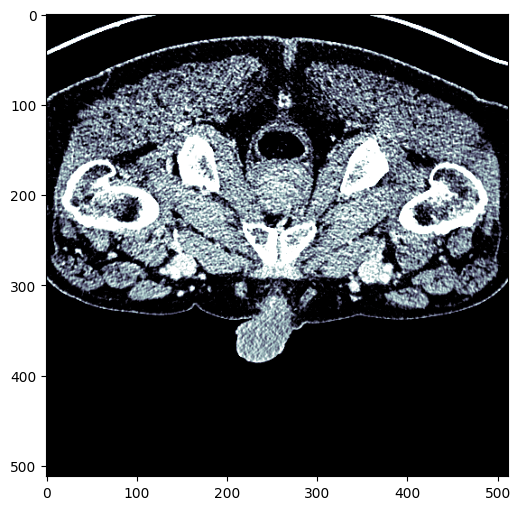

In [6]:
dicom_windows = types.SimpleNamespace(
    brain=(80,40),
    subdural=(254,100),
    stroke=(8,32),
    brain_bone=(2800,600),
    brain_soft=(375,40),
    lungs=(1500,-600),
    mediastinum=(350,50),
    abdomen_soft=(400,50),
    liver=(150,30),
    spine_soft=(250,50),
    spine_bone=(1800,400),
    custom = (200,60)
)

@patch
def windowed(self:Tensor, w, l):
    px = self.clone()
    px_min = l - w//2
    px_max = l + w//2
    px[px<px_min] = px_min
    px[px>px_max] = px_max
    return (px-px_min) / (px_max-px_min)

figure(figsize=(8, 6), dpi=100)

plt.imshow(tensor(sample_ct[..., 55].astype(np.float32)).windowed(*dicom_windows.liver), cmap=plt.cm.bone);

In [7]:
def plot_sample(array_list, color_map = 'nipy_spectral'):
    '''
    Plots and a slice with all available annotations
    '''
    fig = plt.figure(figsize=(20,16), dpi=100)

    plt.subplot(1,4,1)
    plt.imshow(array_list[0], cmap='bone')
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1,4,2)
    plt.imshow(tensor(array_list[0].astype(np.float32)).windowed(*dicom_windows.liver), cmap='bone');
    plt.title('Windowed Image')
    plt.axis('off')
             
    plt.subplot(1,4,3)
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Mask')
    plt.axis('off')
    
    plt.subplot(1,4,4)
    plt.imshow(array_list[0], cmap='bone')
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Liver & Mask')
    plt.axis('off')
    
    plt.show()

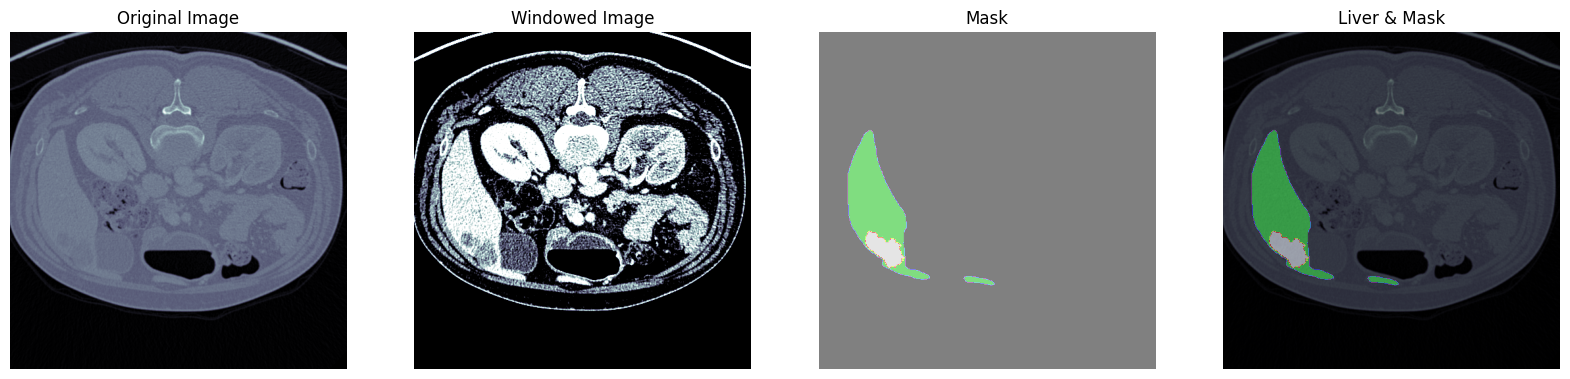

In [8]:
sample = 444

sample_slice = tensor(sample_ct[...,sample].astype(np.float32))

plot_sample([sample_ct[..., sample],
             sample_mask[..., sample]])

In [9]:
# Check the mask values
mask = Image.fromarray(sample_mask[...,sample].astype('uint8'), mode="L")
unique, counts = np.unique(mask, return_counts=True)
print(np.array((unique, counts)).T)

[[     0 249971]
 [     1  10370]
 [     2   1803]]


## Preprocessing functions

<Axes: >

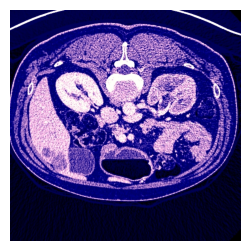

In [10]:
class TensorCTScan(TensorImageBW): _show_args = {'cmap':'bone'}

@patch
def freqhist_bins(self:Tensor, n_bins=100):
    "A function to split the range of pixel values into groups, such that each group has around the same number of pixels"
    imsd = self.view(-1).sort()[0]
    t = torch.cat([tensor([0.001]),
                   torch.arange(n_bins).float()/n_bins+(1/2/n_bins),
                   tensor([0.999])])
    t = (len(imsd)*t).long()
    return imsd[t].unique()
    
@patch
def hist_scaled(self:Tensor, brks=None):
    "Scales a tensor using `freqhist_bins` to values between 0 and 1"
    if self.device.type=='cuda': return self.hist_scaled_pt(brks)
    if brks is None: brks = self.freqhist_bins()
    ys = np.linspace(0., 1., len(brks))
    x = self.numpy().flatten()
    x = np.interp(x, brks.numpy(), ys)
    return tensor(x).reshape(self.shape).clamp(0.,1.)
    
    
@patch
def to_nchan(x:Tensor, wins, bins=None):
    res = [x.windowed(*win) for win in wins]
    if not isinstance(bins,int) or bins!=0: res.append(x.hist_scaled(bins).clamp(0,1))
    dim = [0,1][x.dim()==3]
    return TensorCTScan(torch.stack(res, dim=dim))

@patch
def save_jpg(x:(Tensor), path, wins, bins=None, quality=120):
    fn = Path(path).with_suffix('.jpg')
    x = (x.to_nchan(wins, bins)*255).byte()
    im = Image.fromarray(x.permute(1,2,0).numpy(), mode=['RGB','CMYK'][x.shape[0]==4])
    im.save(fn, quality=quality)

_,axs = subplots(1,1)

sample_slice.save_jpg('test.jpg', [dicom_windows.liver, dicom_windows.custom])
show_image(Image.open('test.jpg'), ax=axs[0], figsize=(8, 6))

In [11]:
# Make custom JPG files for Unet training
# Total number of 131 nii files contains 67072 slices 

GENERATE_JPG_FILES = True

if (GENERATE_JPG_FILES) :
    
    path = Path(".")

    os.makedirs('Extract_Images',exist_ok=True)
    os.makedirs('Extract_Masks',exist_ok=True)

    for ii in tqdm(range(0,len(df_files))): 
        curr_ct        = read_nii(df_files.loc[ii,'dirname']+"/"+df_files.loc[ii,'filename'])
        curr_mask      = read_nii(df_files.loc[ii,'mask_dirname']+"/"+df_files.loc[ii,'mask_filename'])
        curr_file_name = str(df_files.loc[ii,'filename']).split('.')[0]
        curr_dim       = curr_ct.shape[2] # 512, 512, curr_dim

        for curr_slice in range(0,curr_dim): # export every 2nd slice for training
            data = tensor(curr_ct[...,curr_slice].astype(np.float32))
            mask = Image.fromarray(curr_mask[...,curr_slice].astype('uint8'), mode="L")
            data.save_jpg(f"Extract_Images/{curr_file_name}_slice_{curr_slice}.jpg", [dicom_windows.liver,dicom_windows.custom])
            mask.save(f"Extract_Masks/{curr_file_name}_slice_{curr_slice}_mask.png")
else:
    path = Path("../input/liver-segmentation-with-fastai-v2") # read jpg from saved kernel output

  0%|          | 0/131 [00:00<?, ?it/s]

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


In [12]:
import gc
gc.collect()

13760

## Data Directory Names

In [13]:
images = "/kaggle/working/Extract_Images"
masks = "/kaggle/working/Extract_Masks"

In [14]:
# Set parameter
IMAGE_SIZE = (256, 256)

## Create DataFrame

In [15]:
# List all file names in the image folder 
image_paths = []
for root, dirs, files in os.walk(images):
    for file in files:
        file_path = os.path.join(root, file)  
        image_paths.append(file_path)

# Creating mask files list
mask_paths = [path.replace('Extract_Images', 'Extract_Masks').replace('.jpg', '_mask.png') for path in image_paths]

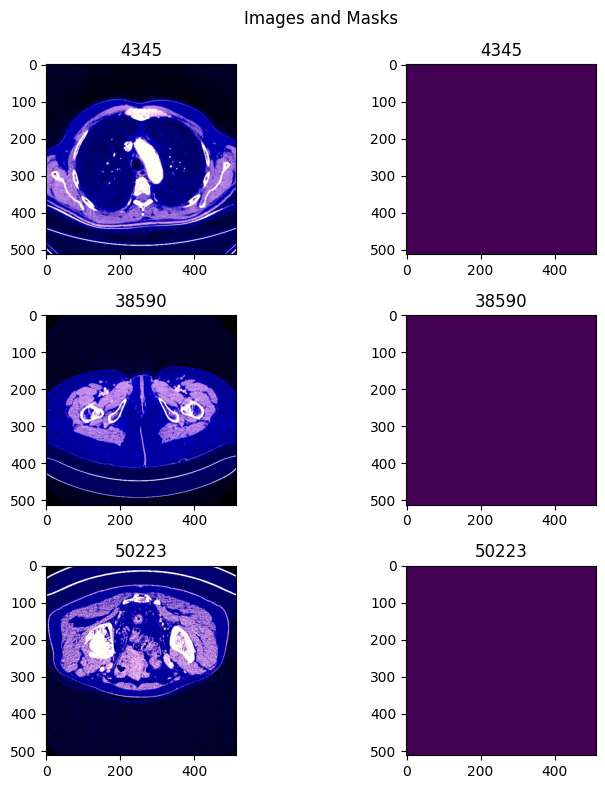

(512, 512, 3) (512, 512)


In [16]:
# Displaying random images and masks for data visualization
fig, axs = plt.subplots(3, 2, figsize=(8, 8))
fig.suptitle("Images and Masks")
indices = []
for i in range(3):
    idx = np.random.choice(len(image_paths))
    indices.append(idx)
    img = imread(image_paths[idx])
    mask = imread(mask_paths[idx])

    axs[i, 0].imshow(img)
    axs[i, 0].set_title(str(idx))

    axs[i, 1].imshow(mask)
    axs[i, 1].set_title(str(idx))

plt.tight_layout()
plt.show()
print(img.shape,mask.shape)

As we can see here most of the maska are empty and act as a noise to our model. We need to remove them, for that we are going to check if the masks are empty or have liver or tumor to segregate them.

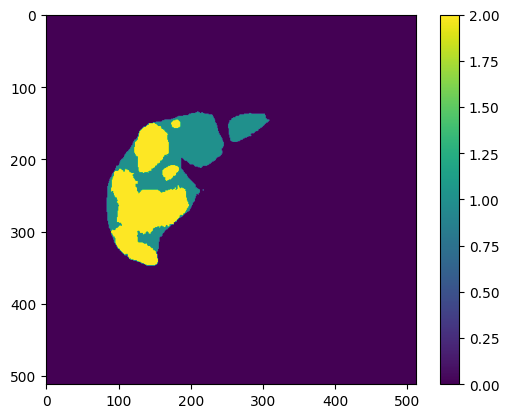

In [17]:
fig, ax = plt.subplots()
mask = cv2.imread('/kaggle/working/Extract_Masks/volume-4_slice_444_mask.png',cv2.IMREAD_GRAYSCALE)
shw = ax.imshow(mask)
bar = plt.colorbar(shw)
plt.show()

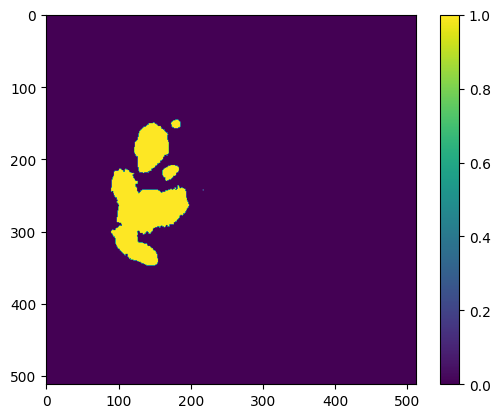

In [18]:
new_mask=np.zeros(mask.shape)
new_mask[mask > 1.50] = 1

fig, ax = plt.subplots() 
shw = ax.imshow(new_mask)
bar = plt.colorbar(shw) 
plt.show()

As we can see here the tumour is greater then 1.50

In [19]:
threshold_percentage = 0
def diagnosis(mask_path):
    mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
    if (np.sum(mask) == 0):
        return '0'
    # Threshold the mask to identify tumor regions
    thresholded_mask = (mask > 1.50).astype(np.uint8)
    # Calculate the percentage of tumor pixels in the binary mask
    tumor_pixel_percentage = (np.sum(thresholded_mask == 1) / thresholded_mask.size) * 100
    # Check if the image contains tumor regions
    if (tumor_pixel_percentage > threshold_percentage):
        return '2'
    else:
        return '1'

Using diagnosis and check_tumor we can know find whats in a mask. 
diagnosis function checks whether the mask is empty or not, if not calculates the percentage of tumor present in every mask, if the percentage is more than 0, it classifies in to mask with tumor.

In [20]:
diagnosis_values = []  # To store the diagnosis values
for mask_path in tqdm(mask_paths, desc='Processing'):
    diagnosis_values.append(diagnosis(mask_path))

df = pd.DataFrame({"image_path": image_paths, "mask_path": mask_paths, "diagnosis": diagnosis_values})
df.head()

Processing:   0%|          | 0/58638 [00:00<?, ?it/s]

image_path  \
0  /kaggle/working/Extract_Images/volume-119_slice_384.jpg   
1    /kaggle/working/Extract_Images/volume-7_slice_265.jpg   
2   /kaggle/working/Extract_Images/volume-82_slice_403.jpg   
3  /kaggle/working/Extract_Images/volume-122_slice_181.jpg   
4    /kaggle/working/Extract_Images/volume-8_slice_238.jpg   

                                                     mask_path diagnosis  
0  /kaggle/working/Extract_Masks/volume-119_slice_384_mask.png         0  
1    /kaggle/working/Extract_Masks/volume-7_slice_265_mask.png         0  
2   /kaggle/working/Extract_Masks/volume-82_slice_403_mask.png         2  
3  /kaggle/working/Extract_Masks/volume-122_slice_181_mask.png         1  
4    /kaggle/working/Extract_Masks/volume-8_slice_238_mask.png         0

# <div id="chap3"><h1 style="color:white;background:#5963ab;border-radius:5px;padding:30px;font-family:'Arial', cursive;font-size:50px;text-align:center">Data Preprocessing</h1></div>

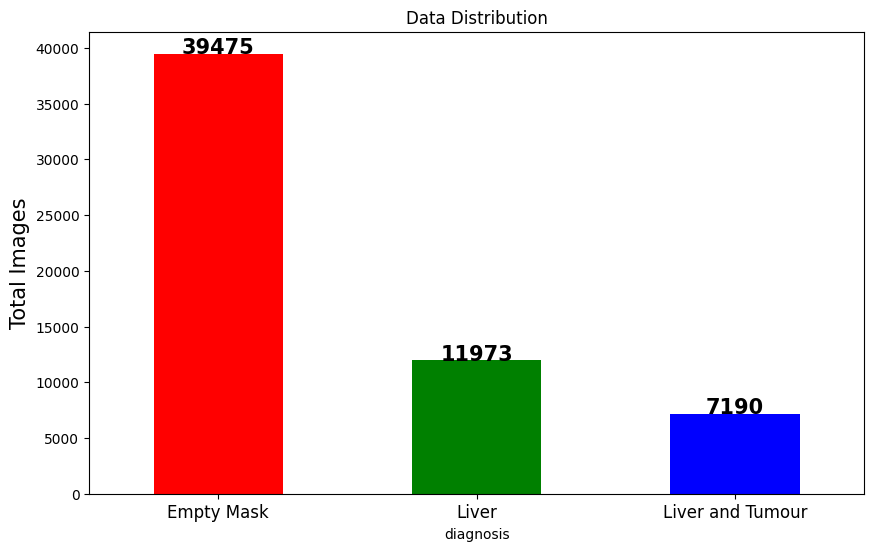

In [21]:
ax = df['diagnosis'].value_counts().plot(kind='bar', stacked=True, figsize=(10,6), color=['red','green', 'blue'])
ax.set_title('Data Distribution')
ax.set_ylabel('Total Images', fontsize=15)
ax.set_xticklabels(['Empty Mask', 'Liver','Liver and Tumour'], fontsize=12, rotation=0)
for i, rows in enumerate(df['diagnosis'].value_counts().values):
    ax.annotate(int(rows), xy=(i, rows+12), ha='center', fontweight='bold', fontsize=15)

### Visualize scans with Mask

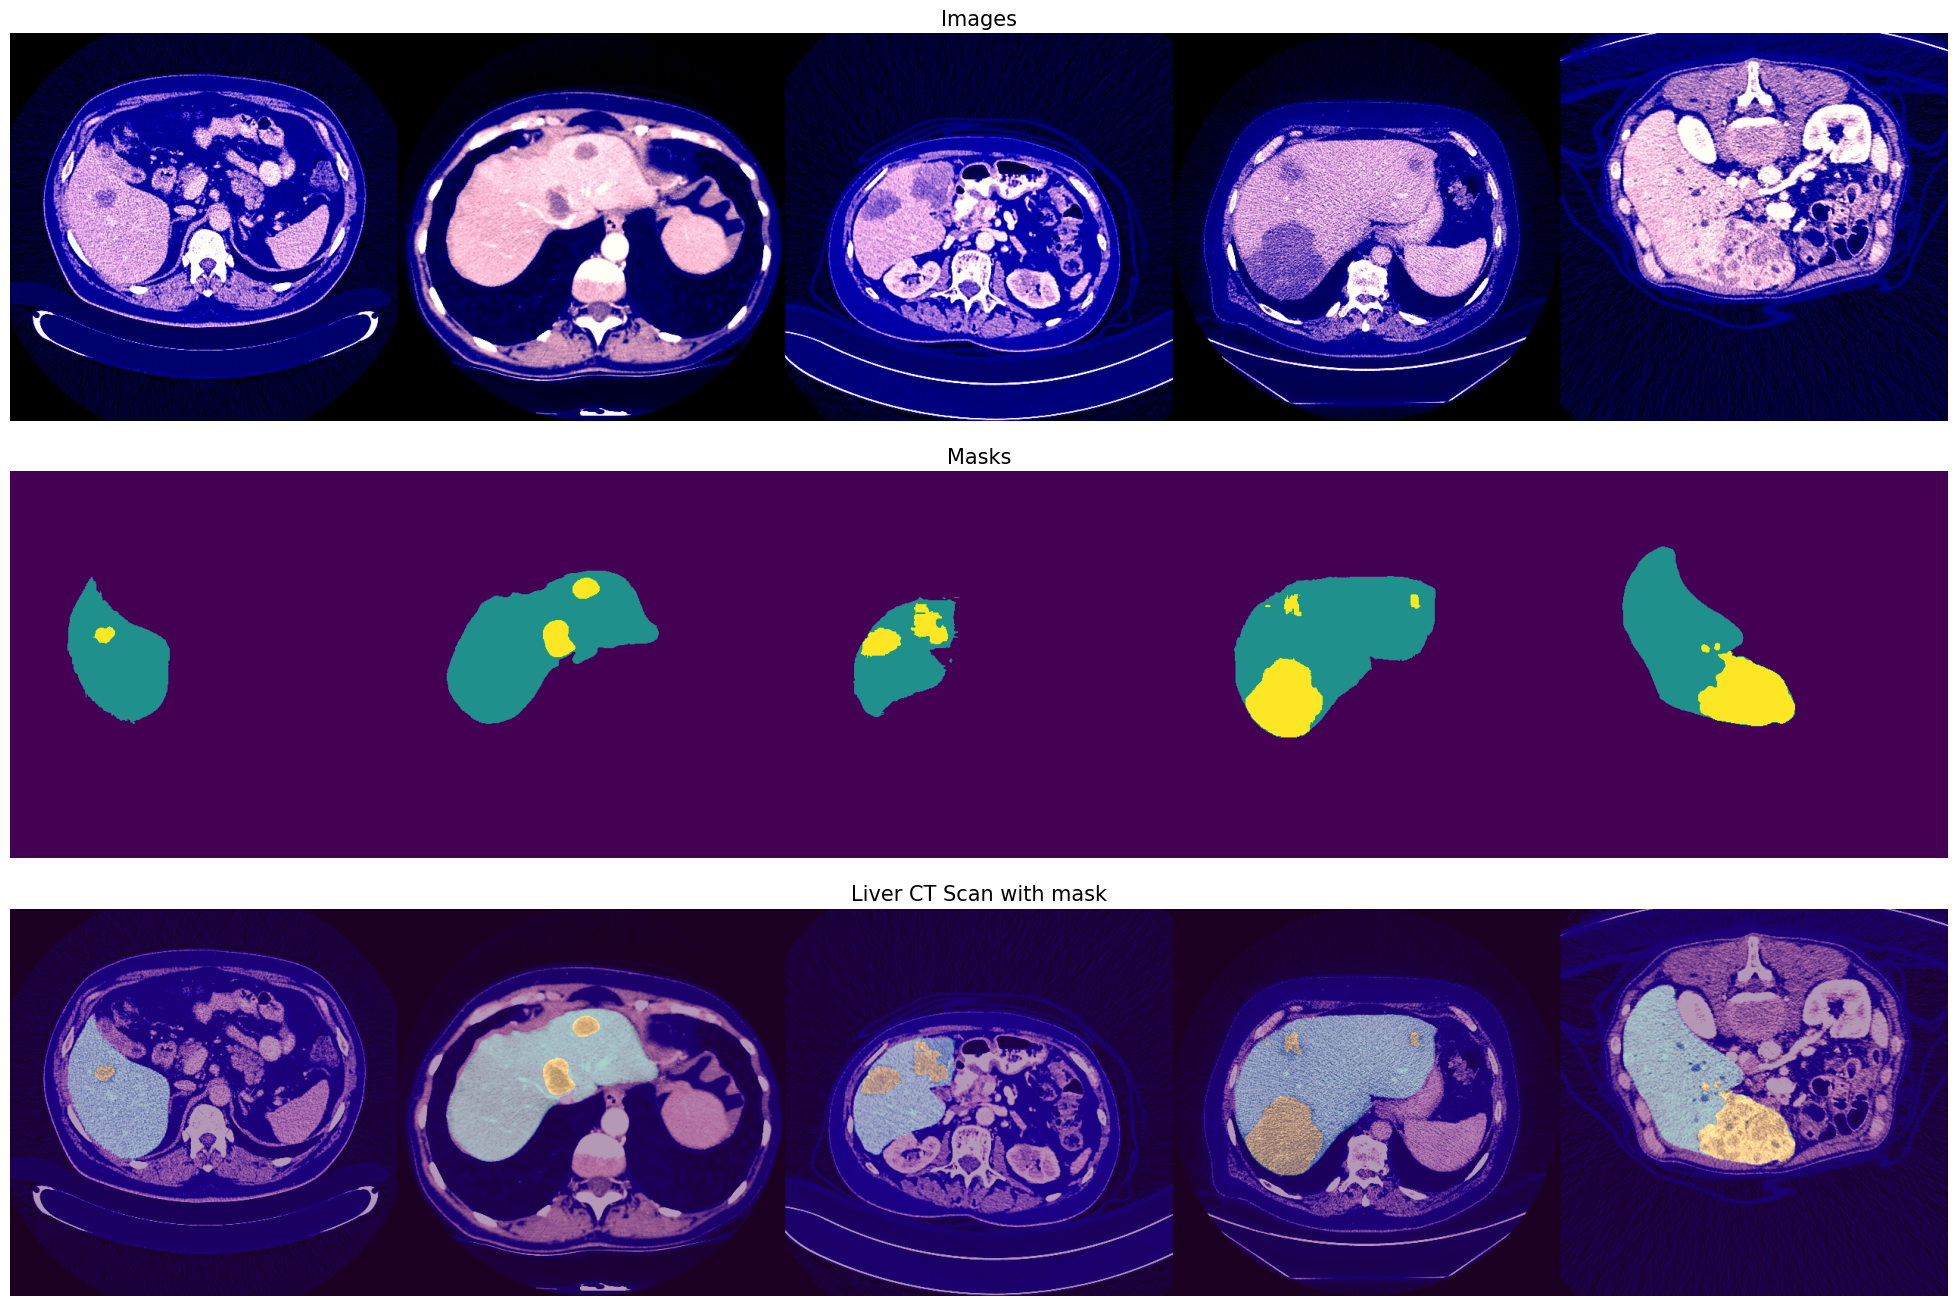

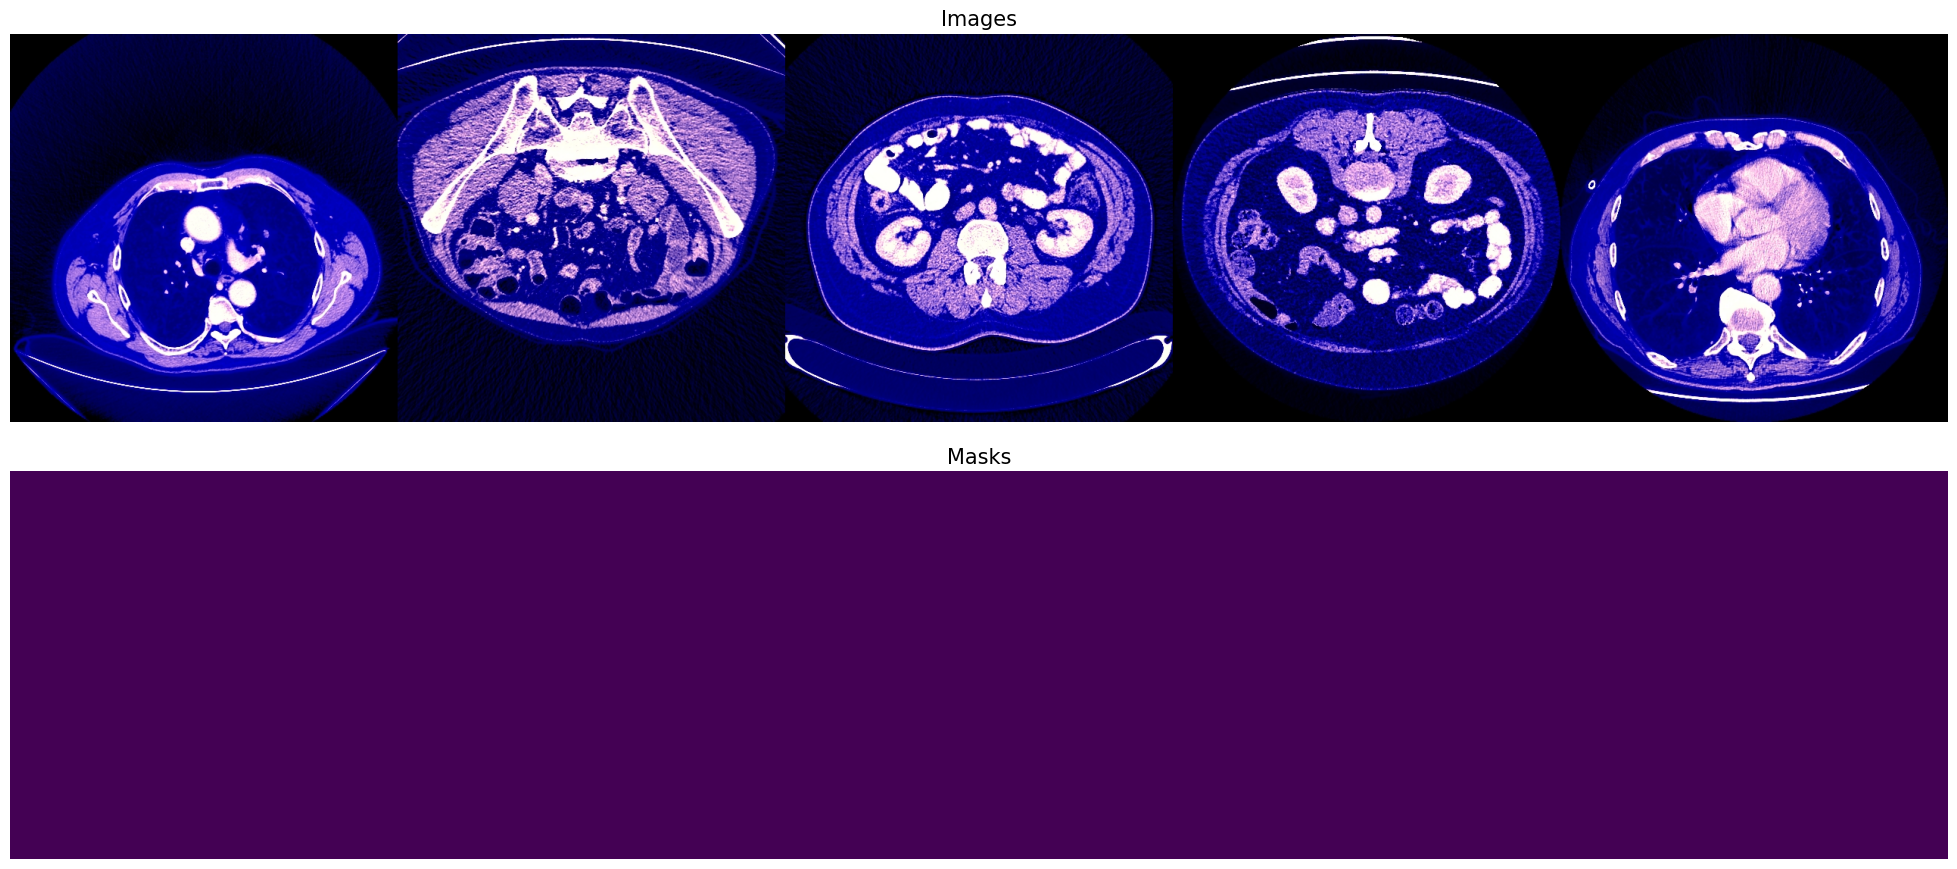

In [22]:
df_positive = df[df['diagnosis']== '2'].sample(5).values
df_negative = df[df['diagnosis']== '0'].sample(5).values

def show_data(df, positive):
    images = []
    masks = []
    for data in df:
        img = imread(data[0])
        mask = imread(data[1])
        images.append(img)
        masks.append(mask)
    images = np.hstack(np.array(images))
    masks = np.hstack(np.array(masks))
    
    fig = plt.figure(figsize=(25,25))
    if positive:
        grid = ImageGrid(fig, 111, nrows_ncols=(3,1), axes_pad=0.5)
    else:
        grid = ImageGrid(fig, 111, nrows_ncols=(2,1), axes_pad=0.5)
    grid[0].imshow(images)
    grid[0].set_title('Images', fontsize=15)
    grid[0].axis('off')
    grid[1].imshow(masks)
    grid[1].set_title('Masks', fontsize=15)
    grid[1].axis('off')
    if positive:
        grid[2].imshow(images)
        grid[2].imshow(masks, alpha=0.4)
        grid[2].set_title('Liver CT Scan with mask', fontsize=15)
        grid[2].axis('off')
        
show_data(df_positive, positive=True)
show_data(df_negative, positive=False)

### Considering only masks with tumor

In [23]:
df = df[(df['diagnosis'] != '0')&(df['diagnosis'] != '1')]
df.reset_index(drop = True, inplace=True)

In [24]:
df.shape

(7190, 3)

In [25]:
df

image_path  \
0     /kaggle/working/Extract_Images/volume-82_slice_403.jpg   
1     /kaggle/working/Extract_Images/volume-27_slice_486.jpg   
2     /kaggle/working/Extract_Images/volume-93_slice_363.jpg   
3     /kaggle/working/Extract_Images/volume-10_slice_345.jpg   
4     /kaggle/working/Extract_Images/volume-28_slice_110.jpg   
...                                                      ...   
7185  /kaggle/working/Extract_Images/volume-56_slice_194.jpg   
7186   /kaggle/working/Extract_Images/volume-39_slice_83.jpg   
7187  /kaggle/working/Extract_Images/volume-17_slice_375.jpg   
7188   /kaggle/working/Extract_Images/volume-29_slice_67.jpg   
7189   /kaggle/working/Extract_Images/volume-45_slice_34.jpg   

                                                       mask_path diagnosis  
0     /kaggle/working/Extract_Masks/volume-82_slice_403_mask.png         2  
1     /kaggle/working/Extract_Masks/volume-27_slice_486_mask.png         2  
2     /kaggle/working/Extract_Masks/volume-93_slice_363_mask.png         2  
3     /kaggle/working/Extract_Masks/volume-10_slice_345_mask.png         2  
4     /kaggle/working/Extract_Masks/volume-28_slice_110_mask.png         2  
...                                                          ...       ...  
7185  /kaggle/working/Extract_Masks/volume-56_slice_194_mask.png         2  
7186   /kaggle/working/Extract_Masks/volume-39_slice_83_mask.png         2  
7187  /kaggle/working/Extract_Masks/volume-17_slice_375_mask.png         2  
7188   /kaggle/working/Extract_Masks/volume-29_slice_67_mask.png         2  
7189   /kaggle/working/Extract_Masks/volume-45_slice_34_mask.png         2  

[7190 rows x 3 columns]

### Train, Test, Validation Split

In [26]:
df = df.sample(frac=1,random_state = 32)

In [27]:
# df_train = df[:3000]
# df_val = df[3000:3400]
# df_test = df[3400:]

In [28]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.1)
df_train, df_val = train_test_split(df_train, test_size=0.15)
print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)

(5500, 3)
(971, 3)
(719, 3)


# <div id="chap4"><h1 style="color:white;background:#5963ab;border-radius:5px;padding:30px;font-family:'Arial', cursive;font-size:50px;text-align:center">Data Generator, Data Augmentation</h1></div>

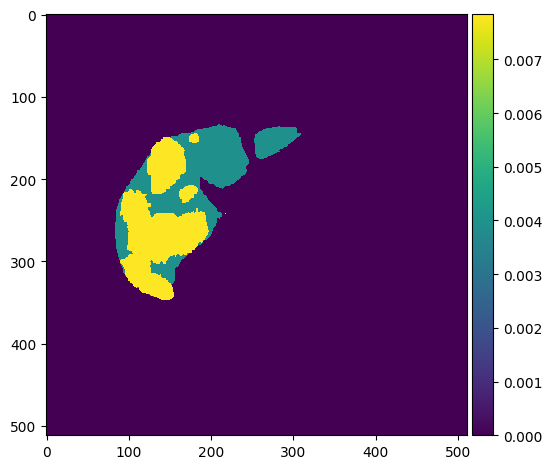

In [29]:
mask = cv2.imread('/kaggle/working/Extract_Masks/volume-4_slice_444_mask.png',cv2.IMREAD_GRAYSCALE)
mask = mask/255.
imshow(mask)

As we can see her the tumour value after normalization is greater than 0.006, so we will consider this to convert the masks to binary masks i.e, with only tumour 

In [30]:
def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):

    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "image_path",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask_path",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

# adjust_data function makes the masks with liver and tumor into only tumor,
# this converts the multi-class segmentation into binary segmentation, it also normalizes the images
def adjust_data(img,mask):
    img = img / 255.
    mask = mask / 255.
    new_mask=np.zeros(mask.shape)
    new_mask[mask > 0.006] = 1
    mask = new_mask
    
    return (img, mask)

These is to check whether the data generator function is working correctly

In [31]:
# batch_size = 32
# data_generator = train_generator(
#     batch_size=batch_size,
#     data_frame=df_val,  
#     aug_dict={},
# )
# for batch_idx, (images, masks) in enumerate(data_generator):
#     print(f"Batch {batch_idx + 1}, Images shape: {images.shape}, Masks shape: {masks.shape}")
#     plt.subplot(121)
#     plt.imshow(images[0])
#     plt.title("Image")
#     plt.subplot(122)
#     plt.imshow(masks[0], cmap='gray') 
#     plt.title("Mask")
#     plt.show()
#     break

In [32]:
# rows = 4
# columns = 8
# fig, axs = plt.subplots(rows, columns, figsize=(24, 12))

# for i in range(rows):
#     for j in range(columns):
#         index = i * columns + j
#         if index < masks.shape[0]:
#             mask_image = masks[index, :, :]
#             axs[i, j].imshow(mask_image)
#             axs[i, j].axis('off')
            
# plt.tight_layout()
# plt.show()

### Defining loss function and metrics

In [33]:
smooth=1.

def dice_coef(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred)
    return (2.0 * intersection + smooth) / (union + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    return dice_coef_loss(y_true, y_pred) + bce(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

# <div id="chap5"><h1 style="color:white;background:#5963ab;border-radius:5px;padding:30px;font-family:'Arial', cursive;font-size:50px;text-align:center">Training U-Net</h1></div>

### Define UNet Model

In [34]:
def unet(input_size=(256,256,3)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(64, (3, 3), padding='same')(inputs)
    bn1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, (3, 3), padding='same')(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation('relu')(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(128, (3, 3), padding='same')(pool1)
    bn2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, (3, 3), padding='same')(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation('relu')(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(256, (3, 3), padding='same')(pool2)
    bn3 = Activation('relu')(conv3)
    conv3 = Conv2D(256, (3, 3), padding='same')(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation('relu')(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = Conv2D(512, (3, 3), padding='same')(pool3)
    bn4 = Activation('relu')(conv4)
    conv4 = Conv2D(512, (3, 3), padding='same')(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation('relu')(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(1024, (3, 3), padding='same')(pool4)
    bn5 = Activation('relu')(conv5)
    conv5 = Conv2D(1024, (3, 3), padding='same')(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation('relu')(bn5)

    up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bn5), conv4], axis=3)
    conv6 = Conv2D(512, (3, 3), padding='same')(up6)
    bn6 = Activation('relu')(conv6)
    conv6 = Conv2D(512, (3, 3), padding='same')(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation('relu')(bn6)

    up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(bn6), conv3], axis=3)
    conv7 = Conv2D(256, (3, 3), padding='same')(up7)
    bn7 = Activation('relu')(conv7)
    conv7 = Conv2D(256, (3, 3), padding='same')(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation('relu')(bn7)

    up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(bn7), conv2], axis=3)
    conv8 = Conv2D(128, (3, 3), padding='same')(up8)
    bn8 = Activation('relu')(conv8)
    conv8 = Conv2D(128, (3, 3), padding='same')(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation('relu')(bn8)

    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(bn8), conv1], axis=3)
    conv9 = Conv2D(64, (3, 3), padding='same')(up9)
    bn9 = Activation('relu')(conv9)
    conv9 = Conv2D(64, (3, 3), padding='same')(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation('relu')(bn9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(bn9)

    return Model(inputs=[inputs], outputs=[conv10])

## Training

In [35]:
# Set parameters
EPOCHS = 55
BATCH_SIZE = 32
learning_rate = 1e-4

In [36]:
train_generator_args = dict(rotation_range=0.1,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            vertical_flip=True,
                            fill_mode='nearest')

train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_args,
                                target_size=IMAGE_SIZE)
    
val_gen = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=IMAGE_SIZE)
    
model = unet(input_size=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

# # learning rate schedule
# def lr_schedule(epoch):
#     if epoch < 30:
#         return 1e-4
#     else:
#         return 1e-5 

# opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=False)
opt = Adam(learning_rate = learning_rate)
model.compile(optimizer=opt, 
              loss=bce_dice_loss, 
              metrics=['accuracy', iou, dice_coef])

callbacks = [ModelCheckpoint('unet_seg.hdf5', verbose=0, save_best_only=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, min_lr=1e-11),
            EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=5)]
#             LearningRateScheduler(lr_schedule)]

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 256, 256, 64)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 64)         36928     ['activation[0][0]']          
                                                                                              

In [37]:
history = model.fit(train_gen,
                    steps_per_epoch=len(df_train) / BATCH_SIZE, 
                    epochs=EPOCHS, 
                    callbacks=callbacks,
                    validation_data = val_gen,
                    validation_steps=len(df_val) / BATCH_SIZE)

Found 5500 validated image filenames.
Found 5500 validated image filenames.
Epoch 1/55
172/171 [==============================] - ETA: 0s - loss: 1.0675 - accuracy: 0.9783 - iou: 0.0555 - dice_coef: 0.1035Found 971 validated image filenames.
Found 971 validated image filenames.
171/171 [==============================] - 195s 939ms/step - loss: 1.0675 - accuracy: 0.9783 - iou: 0.0555 - dice_coef: 0.1035 - val_loss: 1.1151 - val_accuracy: 0.9910 - val_iou: 0.0150 - val_dice_coef: 0.0295 - lr: 1.0000e-04
Epoch 2/55
171/171 [==============================] - 130s 758ms/step - loss: 0.8609 - accuracy: 0.9909 - iou: 0.1190 - dice_coef: 0.2115 - val_loss: 1.0354 - val_accuracy: 0.9911 - val_iou: 0.0127 - val_dice_coef: 0.0250 - lr: 1.0000e-04
Epoch 3/55
171/171 [==============================] - 130s 754ms/step - loss: 0.7536 - accuracy: 0.9926 - iou: 0.1766 - dice_coef: 0.2973 - val_loss: 0.8375 - val_accuracy: 0.9934 - val_iou: 0.1100 - val_dice_coef: 0.1953 - lr: 1.0000e-04
Epoch 4/55
171/

# <div id="chap6"><h1 style="color:white;background:#5963ab;border-radius:5px;padding:30px;font-family:'Arial', cursive;font-size:50px;text-align:center">Inference</h1></div>

### Visualize the model performance

In [38]:
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_iou = hist.history['iou']
    tr_dice = hist.history['dice_coef']
    tr_loss = hist.history['loss']

    val_acc = hist.history['val_accuracy']
    val_iou = hist.history['val_iou']
    val_dice = hist.history['val_dice_coef']
    val_loss = hist.history['val_loss']

    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    
    index_iou = np.argmax(val_iou)
    iou_highest = val_iou[index_iou]
    
    index_dice = np.argmax(val_dice)
    dice_highest = val_dice[index_dice]
    
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]

    Epochs = [i+1 for i in range(len(tr_acc))]

    acc_label = f'best epoch= {str(index_acc + 1)}'
    iou_label = f'best epoch= {str(index_iou + 1)}'
    dice_label = f'best epoch= {str(index_dice + 1)}'
    loss_label = f'best epoch= {str(index_loss + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 20))
    plt.style.use('fivethirtyeight')

    # Training Accuracy
    plt.subplot(2, 2, 1)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Training IoU
    plt.subplot(2, 2, 2)
    plt.plot(Epochs, tr_iou, 'r', label= 'Training IoU')
    plt.plot(Epochs, val_iou, 'g', label= 'Validation IoU')
    plt.scatter(index_iou + 1 , iou_highest, s= 150, c= 'blue', label= iou_label)
    plt.title('Training and Validation IoU Coefficient')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.legend()

    # Training Dice
    plt.subplot(2, 2, 3)
    plt.plot(Epochs, tr_dice, 'r', label= 'Training Dice')
    plt.plot(Epochs, val_dice, 'g', label= 'Validation Dice')
    plt.scatter(index_dice + 1 , dice_highest, s= 150, c= 'blue', label= dice_label)
    plt.title('Training and Validation Dice Coefficient')
    plt.xlabel('Epochs')
    plt.ylabel('Dice')
    plt.legend()

    # Training Loss
    plt.subplot(2, 2, 4)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout
    plt.show()

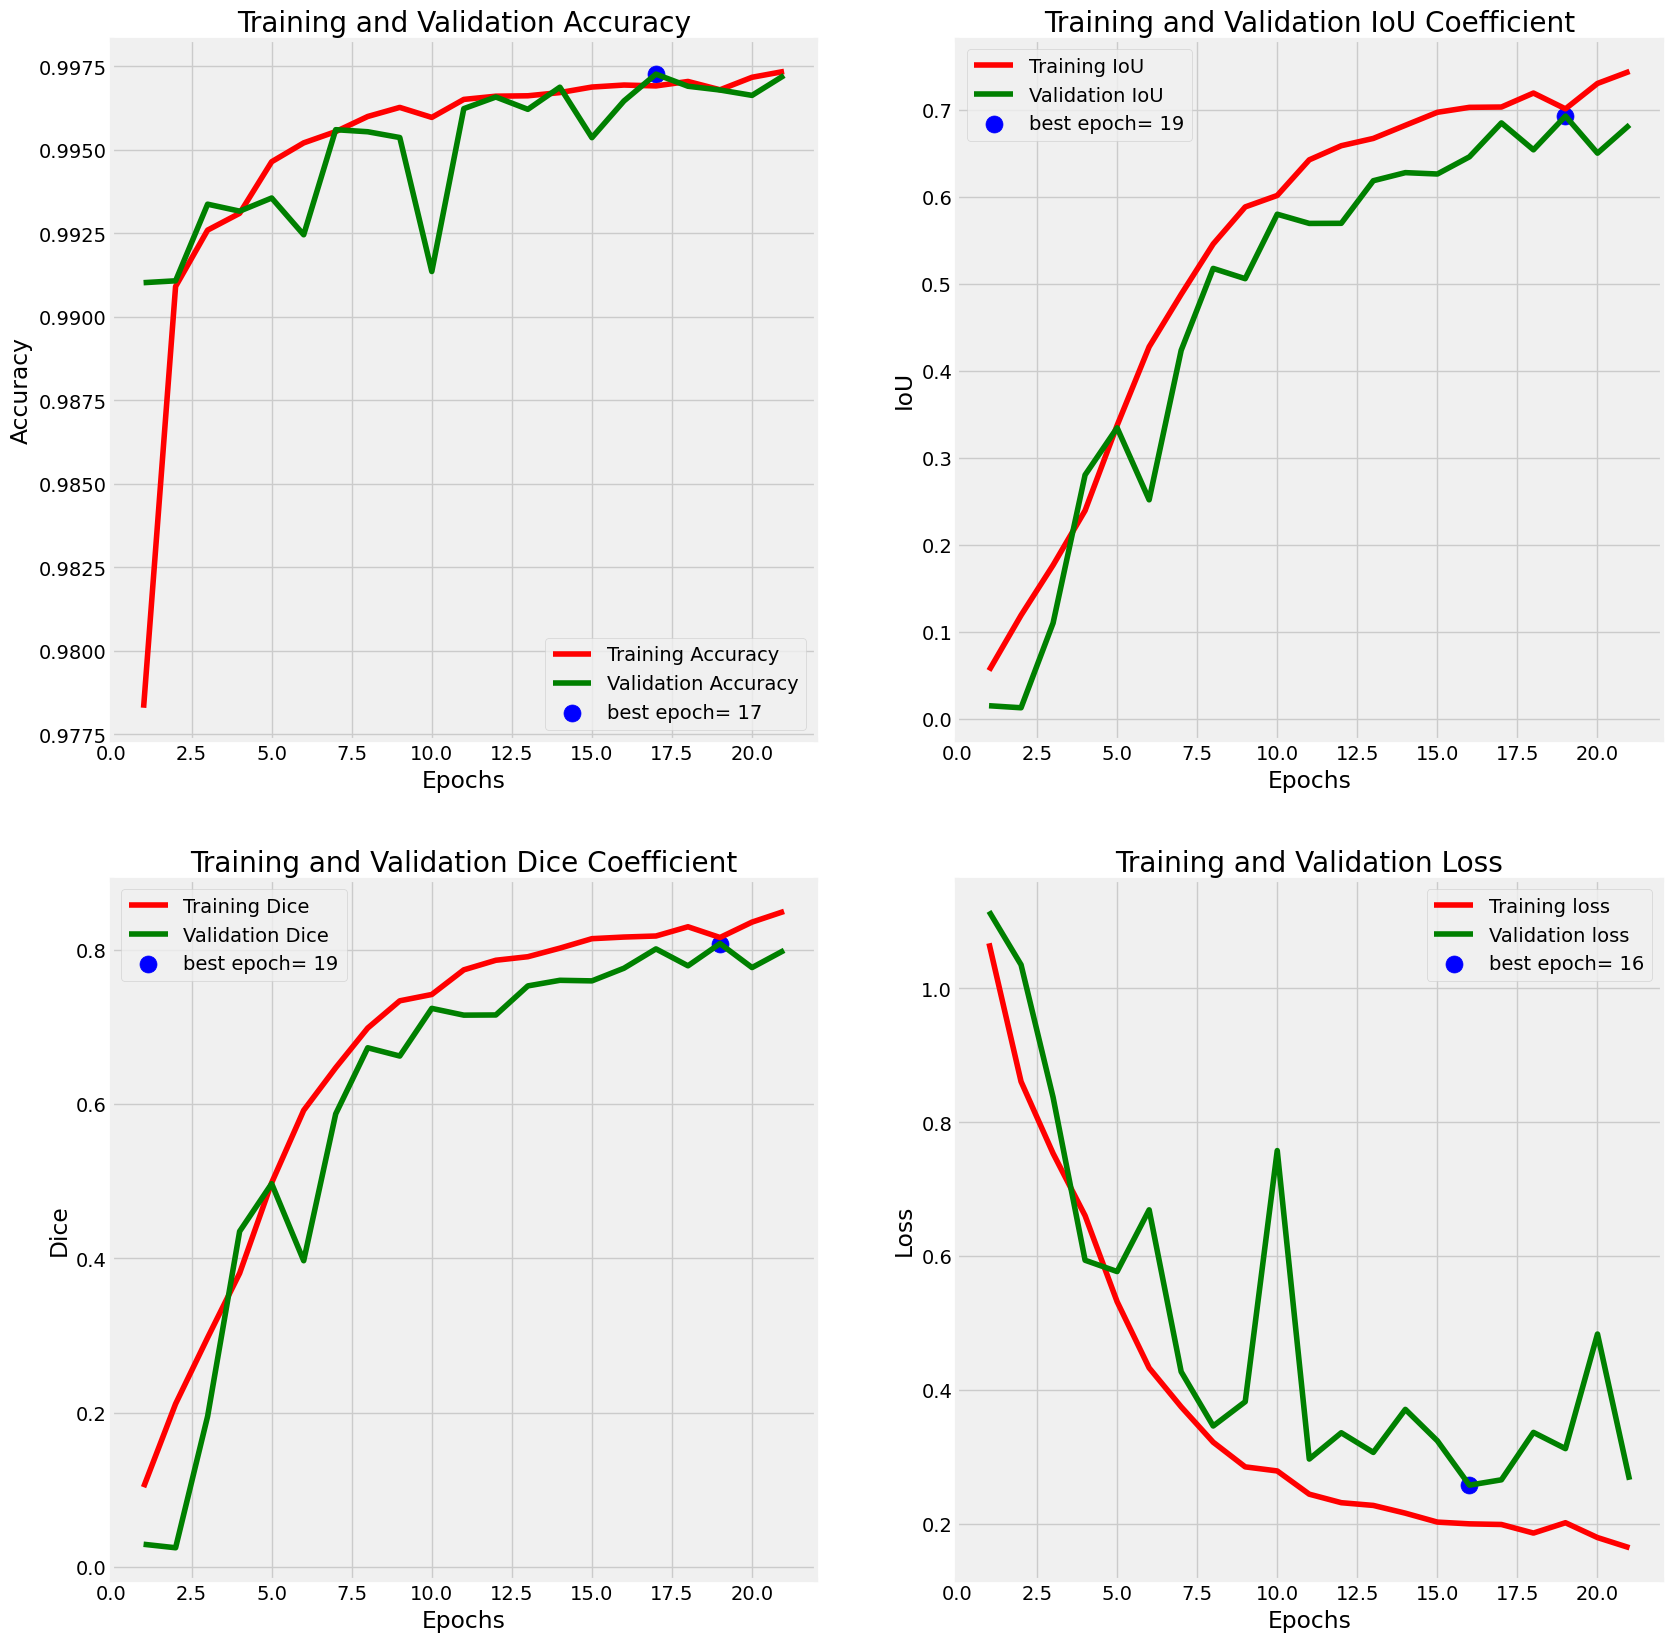

In [39]:
plot_training(history)

## Evaluate the model

In [40]:
model = load_model("/kaggle/working/unet_seg.hdf5",compile = False)

model.compile(optimizer=opt, 
              loss=bce_dice_loss, 
              metrics=['accuracy', iou, dice_coef])

In [41]:
test_gen = train_generator(df_test, BATCH_SIZE,
                                dict(),
                                target_size=IMAGE_SIZE)
results = model.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE)
print("Loss: ",results[0])
print("Accuracy: ",results[1])
print("Test IOU: ",results[2])
print("Test Dice Coefficent: ",results[3])

Found 719 validated image filenames.
Found 719 validated image filenames.
22/22 [==============================] - 10s 410ms/step - loss: 0.2128 - accuracy: 0.9966 - iou: 0.6758 - dice_coef: 0.8059
Loss:  0.21283459663391113
Accuracy:  0.9966481328010559
Test IOU:  0.6757602095603943
Test Dice Coefficent:  0.8058675527572632


### Visualize the Result

In [42]:
# adjust_mask adjusting masks to display with only tumor
def adjust_mask(mask_path):
    mask = cv2.imread(mask_path, 0)       
    mask = cv2.resize(mask, IMAGE_SIZE, interpolation = cv2.INTER_NEAREST)
    mask = mask / 255.
    new_mask=np.zeros(mask.shape)
    new_mask[mask > 0.006] = 1
    return new_mask

1/1 [==============================] - 1s 956ms/step


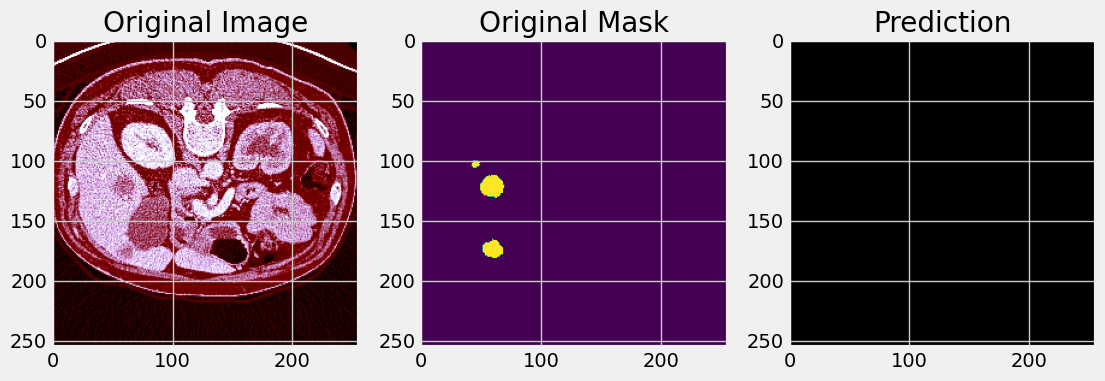

1/1 [==============================] - 0s 20ms/step


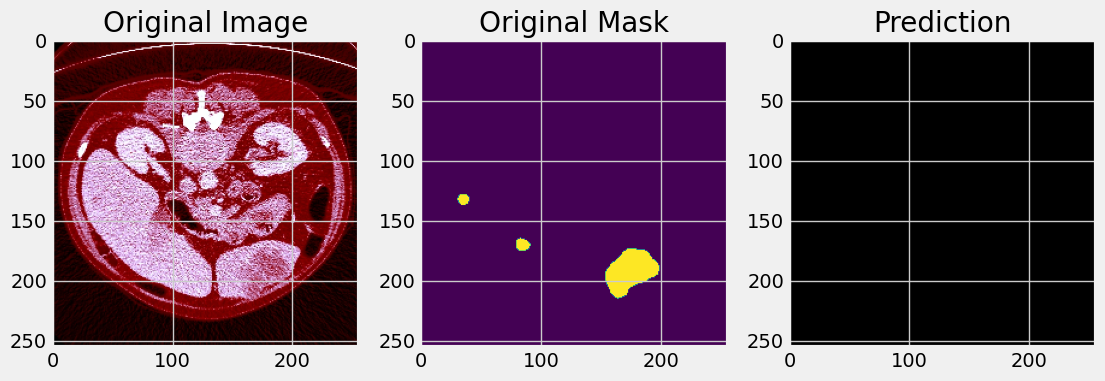

1/1 [==============================] - 0s 22ms/step


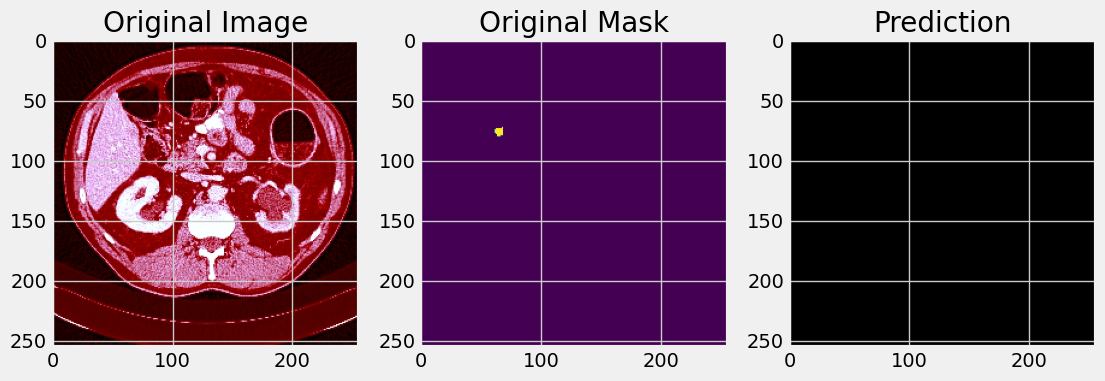

1/1 [==============================] - 0s 21ms/step


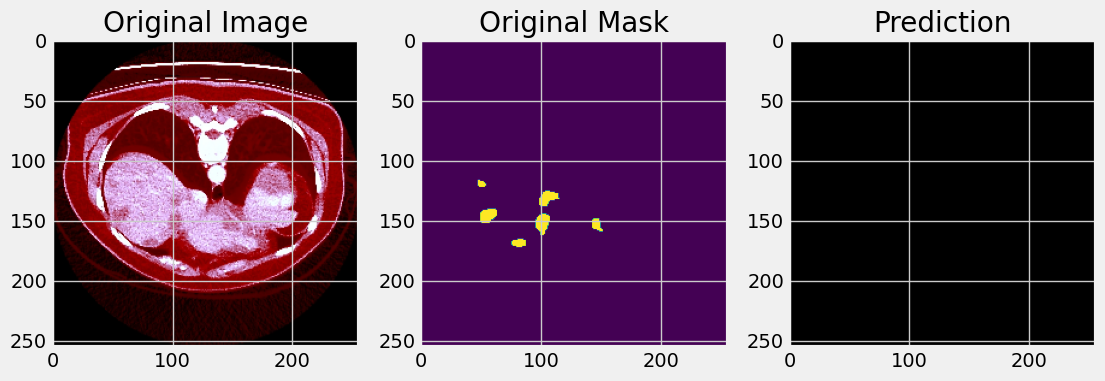

1/1 [==============================] - 0s 21ms/step


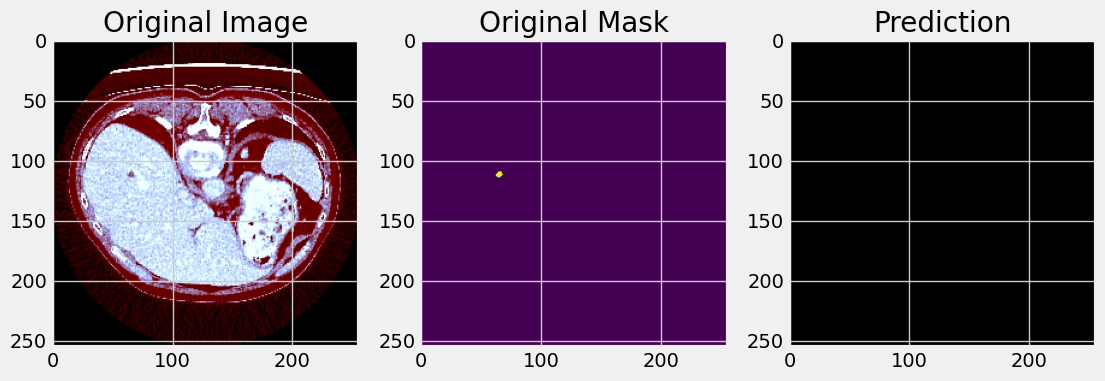

1/1 [==============================] - 0s 20ms/step


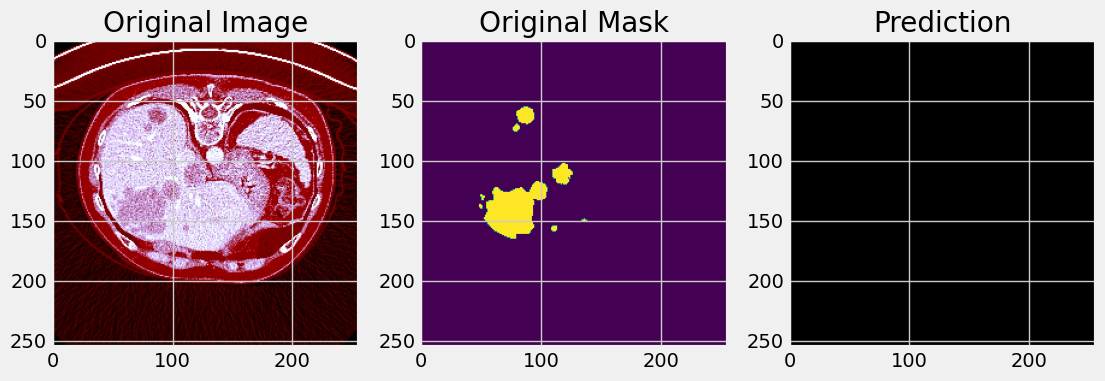

1/1 [==============================] - 0s 21ms/step


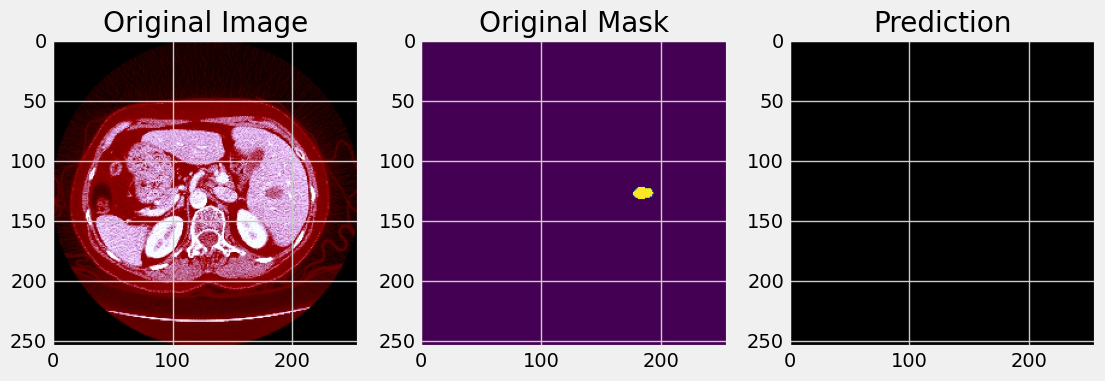

1/1 [==============================] - 0s 19ms/step


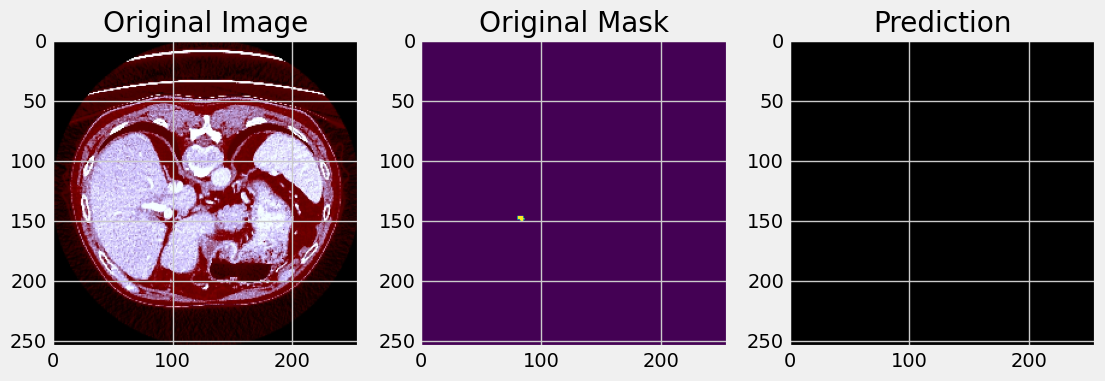

1/1 [==============================] - 0s 20ms/step


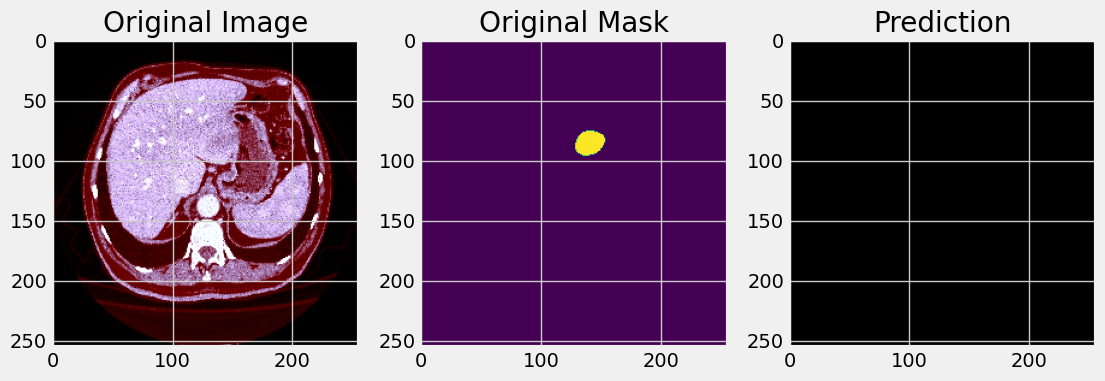

1/1 [==============================] - 0s 19ms/step


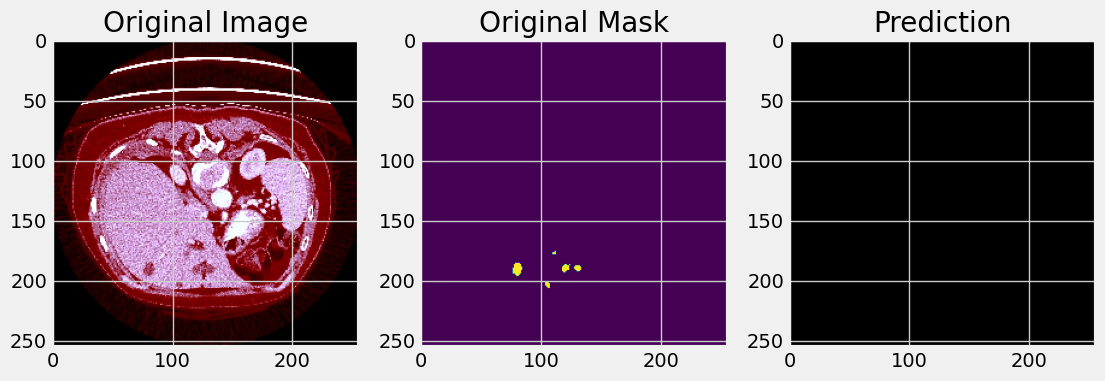

In [43]:
for i in range(10):
    index=np.random.randint(1,len(df_test.index))
    img = cv2.imread(df_test['image_path'].iloc[index])
    img = cv2.resize(img ,IMAGE_SIZE, interpolation = cv2.INTER_NEAREST)
    img = img / 255.
    img = img[np.newaxis, :, :, :]
    
    pred=model.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(adjust_mask(df_test['mask_path'].iloc[index])))
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred) > .006,cmap='gray')
    plt.title('Prediction')
    plt.show()

In [44]:
cor , incor = 0 , 0
for i in range(len(df_test.index)):
    index=i
    img = cv2.imread(df_test['image_path'].iloc[index])
    img = cv2.resize(img ,IMAGE_SIZE)
    img = img / 255.
    img = img[np.newaxis, :, :, :]
    pred = (np.squeeze(model.predict(img)) > 0.006)
    mask = np.squeeze(adjust_mask(df_test['mask_path'].iloc[index]))
    if pred.any() == mask.any():
        cor += 1
    else:
        incor += 1

1/1 [==============================] - 0s 20ms/step


In [45]:
print("Correct = " , cor , "Incorrect = " , incor )
print("Accuracy = " , (cor/(cor+incor)) * 100)

Correct =  7 Incorrect =  712
Accuracy =  0.9735744089012517
